In [1]:
from getpass import getpass
GOOGLE_API_KEY=getpass()

 ········


In [2]:
import os
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass()
    os.environ["LANGSMITH_TRACING"] = "true"

 ········


In [6]:
!pip install langchain-community tqdm langchain-google-genai ipywidgets jq langchain-text-splitters lxml langgraph

## Preprocessing

We first checkout the patient.json file and augment it with a natural language description since that has been shown to have better results
The augmented file is rewritten to comply with the file_path requirement of the JSONLoader

In [3]:
import json

with open("patients.json", "r") as file:
    content = file.read()

obj = json.loads(content)
assert len(obj["patients"]) == 37

In [4]:
def generate_description(patient):
    first_pronoun = 'He' if patient['gender'] == 'Male' else 'She'
    second_pronoun = 'his' if patient['gender'] == 'Male' else 'her'
    return f"""{patient['description'].replace('[AI GENERATED] ', '')}
The name of the patient is {patient['name']}. {first_pronoun} lives at
{patient['address']} and {second_pronoun} phone number is {patient['phone']} and identity is {patient['identity']}.
{first_pronoun} is recommended a {patient['recommended_doctor'].replace('[AI GENERATED] ', '')}.
    """

In [16]:
for i,a in enumerate(obj['patients']):
    obj['patients'][i]['full_desc'] = generate_description(a) 
print(obj['patients'][0])

with open("patients_full.json", "w") as file:
    file.write(json.dumps(obj))

{'name': 'Aisha Khan', 'age': '62', 'gender': 'Female', 'address': 'Mumbai', 'identity': 'Passport: P2947H8', 'phone': '9876543210', 'problems': [{'name': 'Fatigue', 'duration': '2 weeks', 'description': 'Persistent fatigue and weakness.'}, {'name': 'Joint pain', 'duration': '1 month', 'description': 'Pain in knees and elbows.'}, {'name': 'Shortness of breath', 'duration': '1 week', 'description': 'Difficulty breathing after mild exertion.'}], 'conditions': ['Hypertension', 'Osteoarthritis'], 'description': '[AI GENERATED] A 62-year-old female experiencing fatigue, joint pain, and shortness of breath, with a medical history of hypertension and osteoarthritis.', 'recommended_doctor': '[AI GENERATED] Rheumatologist or General Practitioner', 'full_desc': 'A 62-year-old female experiencing fatigue, joint pain, and shortness of breath, with a medical history of hypertension and osteoarthritis.\nThe name of the patient is Aisha Khan. She lives at\nMumbai and her phone number is 9876543210 an

## Load in the documents

The JSON Documents are loaded in using the JSONLoader and the full_desc is the `page_content`.
We also include the entire patient information into document for ease of use. 
This would not be needed if we instead use patient_id

In [5]:
from langchain_community.document_loaders import JSONLoader

def metadata_func(record: dict, metadata: dict):
    del record['full_desc']
    metadata['patient'] = record

    return metadata

loader = JSONLoader(file_path="patients_full.json", 
                    jq_schema=".patients[]", 
                    content_key=".full_desc", 
                    text_content=True, 
                    is_content_key_jq_parsable=True,
                    metadata_func=metadata_func
                   )

docs = loader.load()
print(docs[0])

page_content='A 62-year-old female experiencing fatigue, joint pain, and shortness of breath, with a medical history of hypertension and osteoarthritis.
The name of the patient is Aisha Khan. She lives at
Mumbai and her phone number is 9876543210 and identity is Passport: P2947H8.
She is recommended a Rheumatologist or General Practitioner.
    ' metadata={'source': '/home/noobscience/Projects/rag_learn/patient_system/patients_full.json', 'seq_num': 1, 'patient': {'name': 'Aisha Khan', 'age': '62', 'gender': 'Female', 'address': 'Mumbai', 'identity': 'Passport: P2947H8', 'phone': '9876543210', 'problems': [{'name': 'Fatigue', 'duration': '2 weeks', 'description': 'Persistent fatigue and weakness.'}, {'name': 'Joint pain', 'duration': '1 month', 'description': 'Pain in knees and elbows.'}, {'name': 'Shortness of breath', 'duration': '1 week', 'description': 'Difficulty breathing after mild exertion.'}], 'conditions': ['Hypertension', 'Osteoarthritis'], 'description': '[AI GENERATED] A 6

## Text Splitting

We next split the augmented text document into smaller chunks. This however is kinda unneccessary and is only done for the semantics of the representation

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

assert len(all_splits) == len(docs)

In [7]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=GOOGLE_API_KEY)

In [8]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(documents=all_splits)

['771a0a1b-f1e5-4a68-a548-faad2a5a8650',
 '53b81e25-f6e4-48c2-9b14-5147ee9c253a',
 'f123ad15-8139-425b-a491-853f2b05834e',
 '17c93f7f-f681-415c-9a52-13272800087b',
 '6ce12e06-cf3a-41a0-8783-db86dc41cdf6',
 '5428ba91-df55-498d-85ba-6e9973b8753a',
 '550d12bb-de4b-4594-a5a7-371b089cc538',
 '78e7569c-871a-4cfa-a6a2-5ca82aecfc86',
 '2768b1be-5021-4637-b5e9-86e0acdda5d3',
 '5b945382-3e38-4de9-8252-7b88b4b9352c',
 'c9486eed-88bc-497e-a364-eab0a086e6ee',
 '499a10da-fc26-4cee-8817-31c0e3c6cceb',
 'f3b31c84-4a21-4198-9a6d-ba017d992b17',
 '8656ba2c-ccdd-4aa9-a11d-f291ecfd6358',
 '3f3b9575-8020-47fa-acb0-b8f886d40f98',
 '3368e06e-6c5a-4184-9b2b-6b21a02727e1',
 '7d25f3ca-a697-473b-aa24-97373afd0d3a',
 '4ccb2521-b003-4815-9722-79cfd4fe238a',
 '9b7f76b5-5869-4017-be02-5a3d8754c148',
 'db184357-a1e0-4445-af9b-13e1befabfc4',
 'ee58c742-582d-47f8-9299-74d9e68f5f04',
 '402b61c2-f8d7-4486-9d63-6b8ca61aefbe',
 'e0c58fb0-ca15-4d16-a87c-a60896d85cd1',
 'c627f00d-2861-4d78-8df1-5bd786d779ec',
 'd45a68a3-c12d-

In [9]:
em = embeddings.embed_query("Female with fever")
results = vector_store.similarity_search_with_score_by_vector(embedding=em)
for doc, score in results:
    if score < 0.5: continue
    print(f"* [SIM={score:3f}] {doc.page_content} [{doc.metadata}]")

* [SIM=0.618512] A 34-year-old female experiencing abdominal pain and fever.
The name of the patient is Rani Sharma. She lives at
Udaipur and her phone number is 4545454545 and identity is Driving License: DL1234567890.
She is recommended a General Practitioner. [{'source': '/home/noobscience/Projects/rag_learn/patient_system/patients_full.json', 'seq_num': 25, 'patient': {'name': 'Rani Sharma', 'age': '34', 'gender': 'Female', 'address': 'Udaipur', 'identity': 'Driving License: DL1234567890', 'phone': '4545454545', 'problems': [{'name': 'Abdominal pain', 'duration': '2 days', 'description': 'Lower abdominal pain.'}, {'name': 'Fever', 'duration': '1 day', 'description': 'High fever.'}], 'conditions': [], 'description': '[AI GENERATED] A 34-year-old female experiencing abdominal pain and fever.', 'recommended_doctor': '[AI GENERATED] General Practitioner'}}]
* [SIM=0.555963] A 25-year-old female experiencing sore throat and cough.
The name of the patient is Nisha Verma. She lives at
Shi

Okay well this was the 

In [10]:
from langchain_core.globals import set_llm_cache
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.caches import InMemoryCache

llm = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)

set_llm_cache(InMemoryCache())

In [11]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate.from_template("""You are a doctor's assistant who is tasked with answering the questions of a doctor based on the following patient's data: 
{context}. Answer in a professional tones and remember to only answer from the data available to you. If you do not have the
data or the answer for something, please respond with I do not know. Now answer this question: {question}
""")

In [12]:
from typing import TypedDict, List
from langchain_core.documents import Document
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [13]:
from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search_with_score(state["question"])
    docs = [a[0] for a in retrieved_docs if a[1] > 0.5]
    return {"context": docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile(checkpointer=memory)

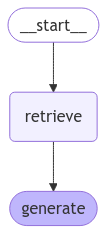

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
config = {"configurable": {"thread_id": "1"}}

def ask(question, config=config):
    res = graph.invoke({"question": question}, config, stream_mode="values")
    for doc in res['context']:
        print(f"Using patient: {doc.metadata['patient']['name']} in context")
    print(res['answer'])

In [63]:
ask("Is there any patient called deepika")

Using patient: Deepika Menon in context
Using patient: Deepika Menon in context
Using patient: Divya Iyer in context
Using patient: Shilpa Reddy in context
Yes, there are two patients named Deepika Menon in the data.



In [59]:
ask("Can you tell me more about them both?")

Please provide me with the patient data so I can answer the doctor's question about them. I need information such as medical history, current medications, and any other relevant details to provide a helpful summary.



## Pivotting to using SQL

Since the embedded vector method is resulting in quite a lot of mistakes (as predicted), we instead pivot to using an SQL query pipeline that has the following structure

START => first_draft_sql => refined_sql => results => llm => END

In [31]:
from db import PatientDatabase

pdb = PatientDatabase()

In [17]:
with open("patients_full.json", "r") as file:
    content = file.read()

pobj = json.loads(content)['patients']

assert len(pobj) != 0

In [20]:
for p in pobj:
    pdb.create_patient(p)

In [22]:
assert len(pdb.select_all_patients()) == len(pobj)

In [24]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///patient_data.db")
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['conditions', 'patients', 'problems']


Well now that we have a good db system in place and working, we can now create a new application state to go along side it

In [25]:
from typing_extensions import TypedDict


class ApplicationState(TypedDict):
    question: str
    query: str
    result: str
    answer: str

Well we would need quite a solid prompt
For now, we shall just try without few shotting it

In [122]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    """Given an input question, create a syntactically correct {dialect} query to run to help find the answer. 
Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your 
query to at most {top_k} results. You can order the results by a relevant column to return the most interesting 
examples in the database.
Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.
Pay attention to use only the column names that you can see in the schema description. Be careful to not query for 
columns that do not exist. Also, pay attention to which column is in which table.
Also whenever possible, try to query all the columns if possible and ensure that the primary key is always included in the query
Only use the following tables:
{table_info}

Here is the schema that binds the tables:
{schema}

Question: {input}
    """)

In [123]:
context = db.get_context()

def write_query(state: ApplicationState):
    res_prompt = prompt.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
            "schema": context["table_info"]
        }
    )
    result = llm.invoke(res_prompt)
    return {"query": result}


def preprocess_query(state: ApplicationState):
    if state["query"] != "":
        state["query"] = state["query"].replace("```", "")
        state["query"] = state["query"].replace("sqlite", "")
        if state["query"].startswith("\n"): 
            state["query"] = state["query"][1:]
        if state["query"].endswith("\n"): 
            state["query"] = state["query"][:-1]

    return {"query": state["query"]}

In [124]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: ApplicationState):
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [114]:
def generate_answer(state: ApplicationState):
    prompt = (
        "You are a doctor's assistant and your job is to answer the following doctor's question: "
        f'Question: {state["question"]}\n'
        f'With this data as the context: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response}

In [125]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(ApplicationState).add_sequence(
    [write_query, preprocess_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()


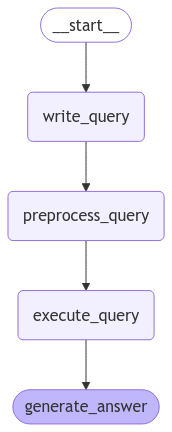

In [102]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [103]:
graph.invoke({"question": "How many patients are there?"})

{'question': 'How many patients are there?',
 'query': 'SELECT COUNT(id) FROM patients',
 'result': '[(37,)]',
 'answer': 'There are 37 patients.\n'}

In [105]:
graph.invoke({"question": "Is there a patient whose name is LIKE Deepika?"})

{'question': 'Is there a patient whose name is LIKE Deepika?',
 'query': "SELECT id, name FROM patients WHERE name LIKE 'Deepika%' LIMIT 10",
 'result': "[(9, 'Deepika Menon'), (37, 'Deepika Menon')]",
 'answer': 'Yes, there are patients whose names are LIKE Deepika. The query returned two patients named Deepika Menon.\n'}

In [121]:
res = graph.invoke({"question": "Can you tell me more about the person whose name is like deepika menon and lives in Goa"})
print(res['answer'])
print(res['query'], res['result'])

Based on the data I have, the person whose name is like Deepika Menon and lives in Goa is:

*   **Name:** Deepika Menon
*   **Age:** 41
*   **Gender:** Female
*   **Location:** Goa
*   **Address:** House Number: 78901
*   **Phone Number:** 6655443322
*   **Presenting Complaint:** Back pain and sciatica.
*   **Suggested Specialist:** Orthopedist or Physiotherapist

SELECT id, name, age, gender, address, identity, phone, description, recommended_doctor FROM patients WHERE name LIKE 'deepika menon' AND address LIKE 'Goa' LIMIT 10 [(9, 'Deepika Menon', 41, 'Female', 'Goa', 'House Number: 78901', '6655443322', '[AI GENERATED] A 41-year-old female presenting with back pain and sciatica.', '[AI GENERATED] Orthopedist or Physiotherapist')]
